## Assignment 1: Analysis Notebook

Jamie Jones

February 16th, 2026

CS 4347


This notebook aims to answer the following question using analysis techniques and a large dataset of all Netflix shows:

Which countries contribute the most titles, and how has that changed over time?

In [1]:
# Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import subprocess
import zipfile

In [2]:
# Sourcing dataset locally

DATA_DIR = Path("data/")

csv_path = DATA_DIR / "netflix_titles.csv"

if csv_path.exists():
    print("Found CSV")
else:
    print("No CSV found")

Found CSV


In [3]:
# Creating pandas dataframe

df = pd.read_csv(csv_path)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Data Dictionary

- show_id: Unique identifier for each title
- type: Movie or TV Show
- title: Name of the title
- director: Director of the title
- cast: Main cast members
- country: Country of production
- date_added: Date the title was added to Netflix
- release_year: Year the title was released
- rating: Age rating (e.g., PG, TV-MA)
- duration: Length in minutes (Movies) or number of seasons (TV Shows)
- listed_in: Genre/category
- description: Short summary of the title


In [4]:
# Quick checks

df.shape
df.columns.tolist()
df.info()
df.isna().sum().sort_values(ascending=False).head(12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64

In [5]:
# Data cleaning

# 1) Drop duplicates
df = df.drop_duplicates()

# 2) Parse date_added to datetime (invalid/missing -> NaT)
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# 3) Create year_added for "titles added over time"
df["year_added"] = df["date_added"].dt.year

# Quick check
df[["date_added", "year_added"]].head()

,date_added,year_added
0,2021-09-25,2021.0
1,2021-09-24,2021.0
2,2021-09-24,2021.0
3,2021-09-24,2021.0
4,2021-09-24,2021.0


## My added function

Returns the first listed country (as a cleaned string).
Netflix 'country' often looks like: "United States, Canada"
If missing, returns np.nan.

In [6]:
# My added function

def first_country(country_value):
    if pd.isna(country_value):
        return np.nan
    return country_value.split(",")[0].strip()

In [7]:
# Applying the above function to our df
df["primary_country"] = df["country"].apply(first_country)

# Quick check
df[["country", "primary_country"]].head(10)


,country,primary_country
0,United States,United States
1,South Africa,South Africa
2,NaN,NaN
3,NaN,NaN
4,India,India
5,NaN,NaN
6,NaN,NaN
7,"United States, Ghana, Burkina Faso, United Kin...",United States
8,United Kingdom,United Kingdom
9,United States,United States


In [8]:
# Final shape after cleaning and modification
print("Final shape after cleaning:", df.shape)

Final shape after cleaning: (8807, 14)


After cleaning, we now have a dataset with parsed dates and a standardized primary country column. This allows for reliable grouping and time-based analysis.

## Analysis Section

Now I will analyze our cleaned dataset with two different methods. First, a grouped summary will show us the top 10 most common countries
Second, a trend over time analysis will show us how the most common countries change as film and tv industries change over time.

In [9]:
# Top 10 countries with grouped summary

top_countries = (
    df["primary_country"]
    .value_counts()
    .head(10)
)

top_countries

primary_country
United States     3211
India             1008
United Kingdom     628
Canada             271
Japan              259
France             212
South Korea        211
Spain              181
Mexico             134
Australia          117
Name: count, dtype: int64

In [11]:
# Country trends over time

top5 = top_countries.index.tolist()

country_trend = (
    df[df["primary_country"].isin(top5)]
    .groupby(["year_added", "primary_country"])
    .size()
    .reset_index(name="count")
)

country_trend

,year_added,primary_country,count
0,2008.0,United States,2
1,2009.0,United States,1
2,2010.0,United States,1
3,2011.0,Spain,1
4,2011.0,United States,12
...,...,...,...
73,2021.0,Mexico,17
74,2021.0,South Korea,27
75,2021.0,Spain,25
76,2021.0,United Kingdom,77


## Visualization of Analysis

This section contains two visuals, one for each method of anaylsis used above.

The first is a bar chart that shows the top 10 countries in terms of total shows on Netflix.

The second is a line plot that shows how the total number of shows grows over time by country of origin.

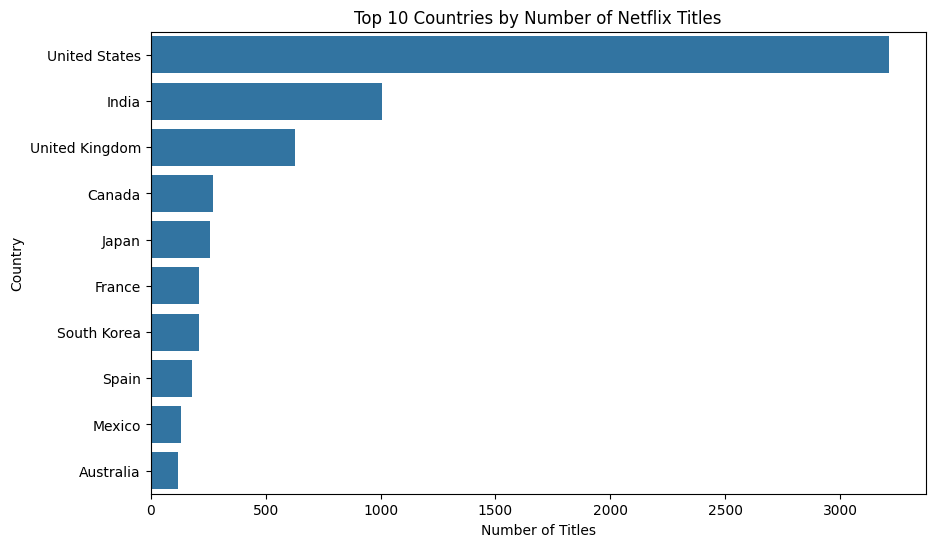

In [12]:
# Bar chart of country totals

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index)

plt.title("Top 10 Countries by Number of Netflix Titles")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.show()

Based on this bar plot, we can see that the United States produces by far the most TV and movies on Netflix, with India at about 1/3rd the US's total and the UK at about 1/4th. No other country comes very close to the production of the top 3, which shows that almost all of TV and movie production for Netflix is concentrated in 2 or 3 countries.

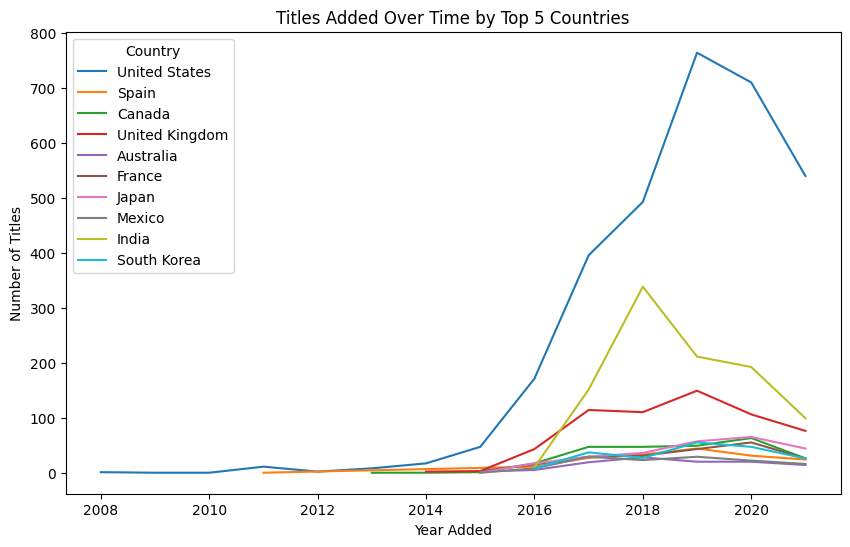

In [ ]:
# Line plot of top 10 countries growth over time

plt.figure(figsize=(10,6))
sns.lineplot(data=country_trend, x="year_added", y="count", hue="primary_country")

plt.title("Titles Added Over Time by Top 5 Countries")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.legend(title="Country")
plt.show()

This line plot shows us that the number of shows and movies on Netflix increased quite sharply from all countries around 2015 and 2016. This displays the rapid global expansion of Netflix as it became a worldwide service at the beginning of the era of streaming. This makes sense, as before 2015, Netflix still delivered movies in the mail using DVDs. The advent of streaming made their business model easily reproducible worldwide.